## Applying LORA (Low Rank Adaption)

Fine-Tuning Image-to-Text conversion algorithms using LORA

Researchers have long grappled with the challenge of fine-tuning in the realm of large language models. Enter Microsoft's innovative solution: Low-Rank Adaptation (LoRA). As models like GPT-3, with their billions of parameters, come into play, the expenses associated with fine-tuning them for particular tasks or sectors skyrocket.

LoRA's pioneering method addresses this by keeping the weights of pre-trained models static and integrating trainable layers—termed rank-decomposition matrices—into every transformer block. This clever strategy drastically cuts down the number of parameters that need training and curtails GPU memory usage, since the need to calculate gradients for most of the model weights is eliminated.

### Libraries
To start with the notebook, the libraries to be used are presented. For the LORA application, it is recommended to have GPU enabled. This is achieved with the last line of the code.

In [1]:
!pip install peft
!pip install transformers
!pip install datasets
!pip install PIL
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 kB 5.8 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL


1. PyTorch for tensor operations.
2. Utilities from PyTorch for handling datasets.
3. The PIL library for image processing.
4. Transformers library, which provides the model and processor for image captioning.
5. The datasets library to load datasets.
6. Peft library for Low-Rank Adaptation.

In [2]:
import torch
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration
from datasets import load_dataset
from peft import LoraConfig, get_peft_model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

This line checks if a GPU (cuda) is available for computation. If not, it defaults to using the CPU. This device setting is later used to move models and data to the appropriate hardware for computation.

## Dataset

We will be using [
blip-image-captioning-base](https://huggingface.co/Salesforce/blip-image-captioning-base) and [
blip-image-captioning-large](https://huggingface.co/Salesforce/blip-image-captioning-large)

In [3]:
loc = "Salesforce/blip-image-captioning-base"
processor = BlipProcessor.from_pretrained(loc)
model = BlipForConditionalGeneration.from_pretrained(loc)
model = model.to(device)

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [4]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [5]:
print_trainable_parameters(model)

trainable params: 247414076 || all params: 247414076 || trainable%: 100.0


In [6]:
#!unzip -q /content/Caption_dataset.zip

## Adapt the Dataset

The implementation of LORA relies on the Peft library.

 However, when confronted with Image-to-Text problems, Peft is not ideally suited for this specific task. Consequently, a series of adjustments must be implemented to ensure seamless compatibility. These modifications are necessary to enhance the framework’s effectiveness in handling the unique challenges posed by Image-to-Text problems.



In [7]:
from PIL import Image
from torch.utils.data import Dataset
import os

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor, image_dir):
        self.dataset = dataset  # This is the loaded JSON dataset
        self.processor = processor  # The processor for image and text
        self.image_dir = image_dir  # Directory where images are stored

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        # Load the image from the path
        image_path = os.path.join(self.image_dir, item["image"])
        try:
            image = Image.open(image_path).convert("RGB")
        except FileNotFoundError:
            raise ValueError(f"Image at path {image_path} not found.")

        # Combine prefix and suffix to create the label (or caption)
        text = f"{item['prefix']} {item['suffix']}".strip()

        # Process the image and text
        encoding = self.processor(images=image, text=text, return_tensors="pt")

        # Check if 'input_ids' exists in encoding, otherwise generate it from text
        if "input_ids" in encoding:
            input_ids = encoding.input_ids
        else:
            input_ids = self.processor(text=text, return_tensors="pt").input_ids

        return {
            "pixel_values": encoding["pixel_values"].squeeze(0),  # Remove batch dim
            "input_ids": input_ids.squeeze(0)  # Remove batch dim
        }

In [8]:
import json
from torch.utils.data import DataLoader
from transformers import AutoProcessor  # Replace with your specific processor

# Paths to your JSON files and image directory
train_json_path = "/kaggle/input/augmenteddataset/train/preprocessed_train.jsonl"
validation_json_path = "/kaggle/input/augmenteddataset/valid/preprocessed_valid.jsonl"
image_directory_1 = "/kaggle/input/augmenteddataset/train"
image_directory_2 = "/kaggle/input/augmenteddataset/valid" # Fixed the variable name here

# Load JSON data
def load_jsonl(jsonl_path):
    data = []
    with open(jsonl_path, "r") as f:
        for line in f:
            data.append(json.loads(line))
    return data

train_data = load_jsonl(train_json_path) # Changed the function call to load_jsonl
validation_data = load_jsonl(validation_json_path) # Changed the function call to load_jsonl


# Create dataset instances
train_dataset = ImageCaptioningDataset(
    dataset=train_data, # Changed data to dataset
    processor=processor,
    image_dir=image_directory_1
)

validation_dataset = ImageCaptioningDataset(
    dataset=validation_data, # Changed data to dataset
    processor=processor,
    image_dir=image_directory_2
)

In [9]:
from torch.nn.utils.rnn import pad_sequence

# Define a custom collate function to pad sequences
def collate_fn(batch):
  input_ids = [item["input_ids"] for item in batch]
  pixel_values = [item["pixel_values"] for item in batch]

  # Pad input_ids
  input_ids = pad_sequence(input_ids, batch_first=True)

  # Assuming pixel_values already have the same shape, no padding needed
  pixel_values = torch.stack(pixel_values)

  return {"input_ids": input_ids, "pixel_values": pixel_values}


In [10]:
# Define batch size
batch_size = 2  # Adjust based on your GPU memory

# Create DataLoaders
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=True  # Shuffle training data
)

validation_dataloader = DataLoader(
    validation_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn
)

## Adapt the model
The subsequent step in our process involves adapting our model for LORA fine-tuning. This crucial adjustment allows our model to effectively harness the power of LORA’s capabilities. For this, we need to instantiate the LORA configuration and determine the corresponding parameters. Subsequently, we list and describe each of them in order to adapt it to each use case.

Furthermore, a handy function has been incorporated that provides insights into the percentage of weights slated for modification. This feature offers transparency and a clear understanding of the extent to which the model’s parameters will be altered during the LORA fine-tuning process.

In [11]:
config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["query","value"],
)

peft_model = get_peft_model(model, config)

Next, some of the main hyperparameters that can be used within the LORA configuration are described.

* r (`int`): Lora attention dimension.
* target_modules (`Union[List[str],str]`): The names of the modules to apply Lora to.
* lora_alpha (`int`): The alpha parameter for Lora scaling.
* lora_dropout (`float`): The dropout probability for Lora layers.
* fan_in_fan_out (`bool`): Set this to True if the layer to replace stores weight like (fan_in, fan_out).
* bias (`str`): Bias type for Lora. Can be ‘none’, ‘all’ or ‘lora_only’ modules_to_save (`List[str]`): List of modules apart from LoRA layers to be set as trainable and saved in the final checkpoint.
* layers_to_transform (`Union[List[int],int]`): The layer indexes to transform, if this argument is specified, it will apply the LoRA transformations on the layer indexes that are specified in this list. If a single integer is passed, it will apply the LoRA transformations on the layer at this index.
* layers_pattern (`str`): The layer pattern name, used only if `layers_to_transform` is different from `None` and if the layer pattern is not in the common layers pattern.

In [12]:
print_trainable_parameters(peft_model)

trainable params: 1179648 || all params: 248593724 || trainable%: 0.4745284720059948


In this case, a reduced batch_size has been applied due to the small number of images. The selected optimizer is AdamW with a total of 100 epochs. The training should take about 1 minute.

## Train

Lastly, the model undergoes training, recovering the loss at the end of each epoch. By leveraging this training methodology, we can effectively monitor and optimize the model’s progress, ultimately leading to enhanced performance and more accurate predictions.

Epoch: 0


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Step 1, Training Loss: 9.632213592529297
Step 2, Training Loss: 8.287995338439941
Step 3, Training Loss: 7.145589828491211
Step 4, Training Loss: 6.661891937255859
Step 5, Training Loss: 5.780600547790527
Step 6, Training Loss: 5.364366054534912
Step 7, Training Loss: 5.641252517700195
Step 8, Training Loss: 3.9284064769744873
Step 9, Training Loss: 5.594557285308838
Step 10, Training Loss: 3.9530487060546875
Step 11, Training Loss: 3.4098896980285645
Step 12, Training Loss: 3.1611173152923584
Step 13, Training Loss: 5.596205234527588
Step 14, Training Loss: 3.072829008102417
Step 15, Training Loss: 4.904980182647705
Step 16, Training Loss: 2.9325156211853027
Step 17, Training Loss: 4.398625373840332
Step 18, Training Loss: 4.737632751464844
Step 19, Training Loss: 4.736318588256836
Step 20, Training Loss: 3.4640417098999023
Step 21, Training Loss: 4.290041923522949
Step 22, Training Loss: 4.145823001861572
Step 23, Training Loss: 2.517432928085327
Step 24, Training Loss: 4.37696743011

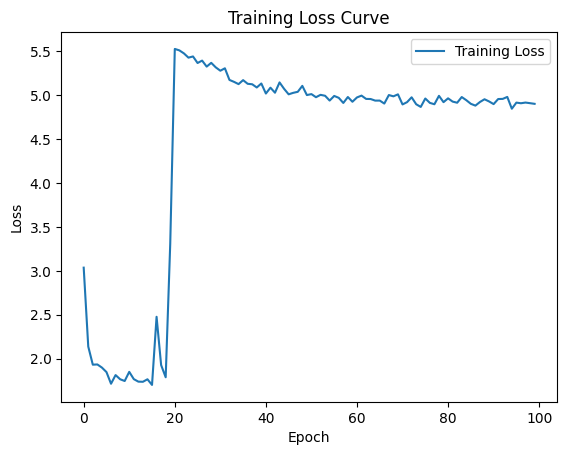

In [13]:
import torch
import matplotlib.pyplot as plt

# Define optimizer and device
optimizer = torch.optim.AdamW(peft_model.parameters(), lr=0.001)
device = "cuda" if torch.cuda.is_available() else "cpu"
peft_model.to(device)

# Set model to train mode
peft_model.train()

# Initialize a list to store the training losses
train_losses = []

# Training loop
for epoch in range(100):  # You can increase the number of epochs as needed
    print("Epoch:", epoch)
    epoch_loss = 0.0
    for idx, batch in enumerate(train_dataloader):
        # Move input tensors to device
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device)

        # Forward pass
        outputs = peft_model(input_ids=input_ids, pixel_values=pixel_values, labels=input_ids)
        loss = outputs.loss

        # Accumulate loss for current step
        epoch_loss += loss.item()

        # Print loss for current step
        print(f"Step {idx + 1}, Training Loss: {loss.item()}")

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Calculate the average loss for the epoch and store it
    avg_epoch_loss = epoch_loss / len(train_dataloader)
    train_losses.append(avg_epoch_loss)

    print(f"Epoch {epoch} Average Training Loss: {avg_epoch_loss}")

# Plotting the loss curve
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()


In [14]:
# Add this code before the training loop to inspect the batch contents
for idx, batch in enumerate(train_dataloader):
  print(batch.keys())
  break

dict_keys(['input_ids', 'pixel_values'])


In [15]:
import torch
from tqdm import tqdm

# Initialize lists to store references and predictions
references = []
predictions = []

# Disable gradient calculations for inference
with torch.no_grad():
    for batch in tqdm(validation_dataloader, desc="Generating Captions"):
        # Move tensors to the device
        pixel_values = batch["pixel_values"].to(device)
        input_ids = batch["input_ids"].to(device)  # May not be needed for generation

        # Generate captions using the model's generate method
        generated_ids = peft_model.generate(
            pixel_values=pixel_values,
            max_length=50,  # Adjust based on your needs
            num_beams=5,    # Beam search parameter
            early_stopping=True
        )

        # Decode the generated ids to strings
        preds = processor.batch_decode(generated_ids, skip_special_tokens=True)
        # Decode the ground truth input_ids to strings
        refs = processor.batch_decode(input_ids, skip_special_tokens=True)

        predictions.extend(preds)
        references.extend(refs)

Generating Captions: 100%|██████████| 139/139 [04:50<00:00,  2.09s/it]


/tmp/ipykernel_23/43585175.py:95: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=3.0)


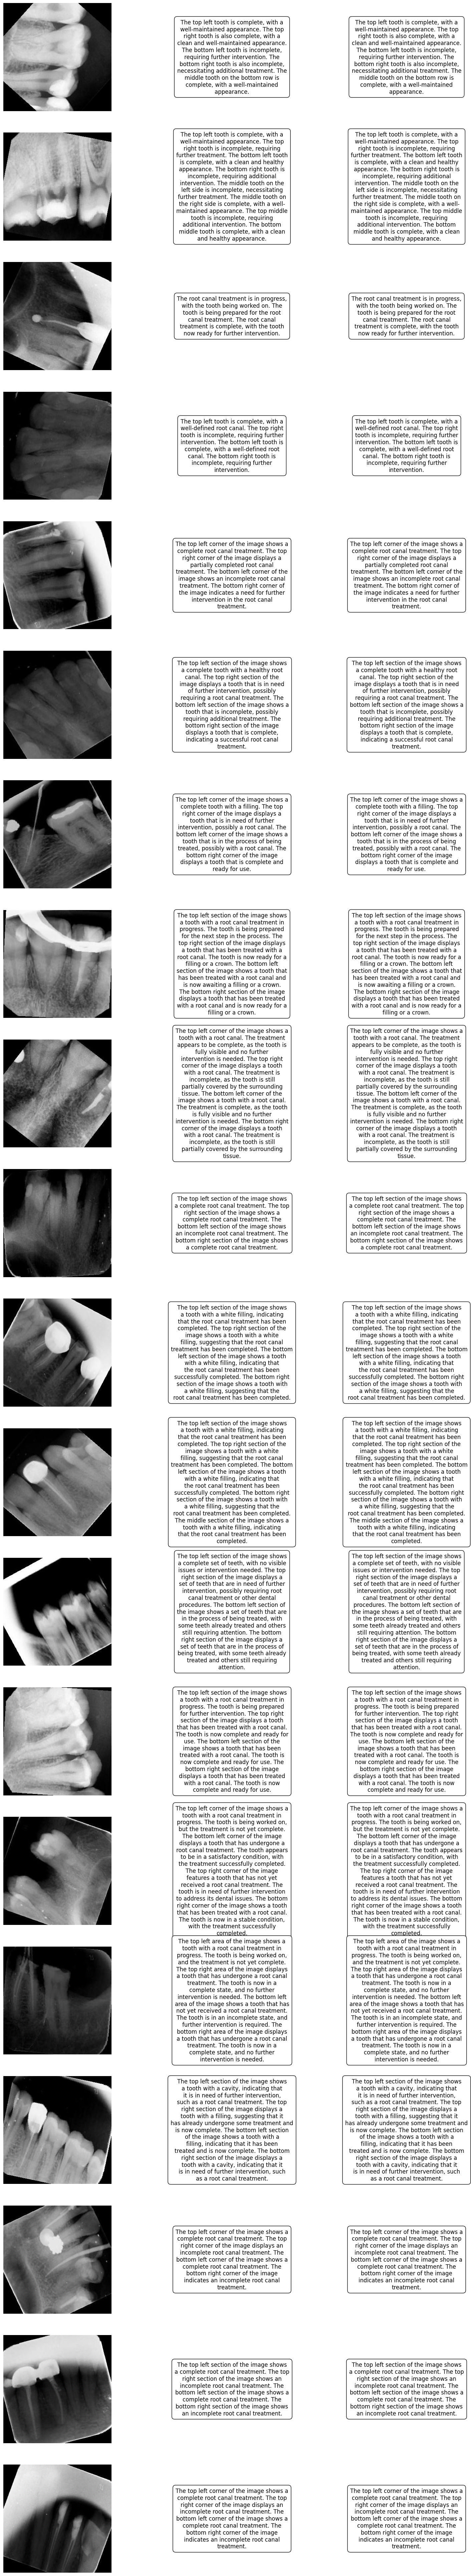

In [16]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import random
import json
import matplotlib.gridspec as gridspec
import textwrap

# Set the number of images you want to display
num_samples = 20

# Path to your images
image_directory = "/kaggle/input/augmenteddataset/valid"  # Replace with the actual path

# Load the JSONL data containing ground truth captions (suffix field)
def load_jsonl(file_path):
    data = []
    with open(file_path, "r") as file:
        for line in file:
            data.append(json.loads(line))
    return data

# Assuming predictions is a list with the same order as the validation_data
validation_jsonl_path = "/kaggle/input/augmenteddataset/valid/preprocessed_valid.jsonl"  # Replace with actual path to your JSONL file
validation_data = load_jsonl(validation_jsonl_path)

# For demonstration, let's create dummy predictions
# Replace this with your actual predictions
predictions = [data["suffix"] + " " for data in validation_data]

# Function to wrap text for better display
def wrap_text(text, width=50):
    return "\n".join(textwrap.wrap(text, width=width))

# Function to display images with ground truth and predictions
def display_images_with_captions(validation_data, predictions, image_dir, num_samples=5):
    # Ensure the number of predictions matches the validation dataset
    assert len(validation_data) == len(predictions), "Mismatch between predictions and validation data size"

    # Randomly sample num_samples images
    random_indices = random.sample(range(len(validation_data)), num_samples)

    # Create a figure with appropriate size
    fig = plt.figure(figsize=(18, 5 * num_samples))  # Adjust width for three columns

    # Create a GridSpec with num_samples rows and 3 columns
    gs = gridspec.GridSpec(num_samples, 3, width_ratios=[1, 1, 1], wspace=0.5)  # Adjust wspace for padding

    for i, idx in enumerate(random_indices):
        # Get the image path, ground truth caption (suffix), and prediction
        image_data = validation_data[idx]
        image_file_name = image_data["image"]
        image_path = os.path.join(image_dir, image_file_name)

        # Check if image path exists
        if not os.path.exists(image_path):
            print(f"Image not found: {image_path}")
            continue

        ground_truth = image_data["suffix"]
        prediction = predictions[idx]

        # Open the image
        image = Image.open(image_path).convert("RGB")

        # Add image to the left column
        ax_image = fig.add_subplot(gs[i, 0])
        ax_image.imshow(image)
        ax_image.axis('off')

        # Add ground truth to the middle column
        ax_gt = fig.add_subplot(gs[i, 1])
        ax_gt.axis('off')

        # Wrap the ground truth text
        wrapped_gt = wrap_text(ground_truth, width=40)

        # Display ground truth caption
        ax_gt.text(0.5, 0.5, wrapped_gt, fontsize=12, verticalalignment='center', horizontalalignment='center',
                   bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
        

        # Add prediction to the right column
        ax_pred = fig.add_subplot(gs[i, 2])
        ax_pred.axis('off')

        # Wrap the prediction text
        wrapped_pred = wrap_text(prediction, width=40)

        # Display prediction caption
        ax_pred.text(0.5, 0.5, wrapped_pred, fontsize=12, verticalalignment='center', horizontalalignment='center',
                     bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
       

    plt.tight_layout(pad=3.0)
    plt.show()

# Call the function to display the images with predictions and ground truth
display_images_with_captions(validation_data, predictions, image_directory, num_samples)


In [17]:
# Install all required packages
!pip install scikit-learn rouge-score git+https://github.com/salaniz/pycocoevalcap.git autocorrect gensim

# Download necessary NLTK data packages
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

from autocorrect import Speller
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import pos_tag
from collections import Counter
import pycocoevalcap.bleu.bleu
import pycocoevalcap.meteor.meteor
import pycocoevalcap.cider.cider
from rouge_score import rouge_scorer
import re

# Initialize spell checker, stemmer, and stop words
spell = Speller()
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

# Function to perform spell correction
def correct_spelling(text):
    return spell(text)

# Function to expand common contractions
contractions = {
    "can't": "cannot", "won't": "will not", "n't": " not", "'re": " are", "'s": " is", "'d": " would", "'ll": " will", "'ve": " have", "'m": " am"
}

def expand_contractions(text):
    for contraction, full_form in contractions.items():
        text = re.sub(contraction, full_form, text)
    return text

# Function for POS filtering to retain meaningful words
def filter_pos(tokens):
    allowed_tags = {'NN', 'VB', 'JJ'}
    return [word for word, tag in pos_tag(tokens) if tag[:2] in allowed_tags]

# Function to remove low-frequency words based on a dataset-wide frequency count
def remove_low_frequency_words(tokens, frequency_dict, threshold=2):
    return [word for word in tokens if frequency_dict[word] > threshold]

# Preprocessing function with advanced techniques
def preprocess_text(text, frequency_dict):
    # Correct spelling errors
    text = correct_spelling(text)

    # Lowercase the text
    text = text.lower()

    # Expand contractions
    text = expand_contractions(text)

    # Remove digits
    text = re.sub(r'\d+', '', text)

    # Remove special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove punctuation and stop words
    tokens = [word for word in tokens if word not in stop_words and word.isalpha()]

    # POS filtering to retain nouns, verbs, adjectives
    tokens = filter_pos(tokens)

    # Apply stemming
    tokens = [stemmer.stem(word) for word in tokens]

    # Remove low-frequency words
    tokens = remove_low_frequency_words(tokens, frequency_dict)

    return ' '.join(tokens).strip()

# Build a frequency dictionary from your dataset
def build_frequency_dict(texts):
    all_words = []
    for text in texts:
        tokens = word_tokenize(text.lower())
        all_words.extend([word for word in tokens if word.isalpha()])
    return Counter(all_words)


# Build frequency dictionary for low-frequency word removal
all_captions = predictions + references
frequency_dict = build_frequency_dict(all_captions)

# Preprocess predictions and references
preprocessed_predictions = [preprocess_text(pred, frequency_dict) for pred in predictions]
preprocessed_references = [preprocess_text(ref, frequency_dict) for ref in references]

# Convert lists to dictionaries with image IDs as keys
gts = {i: [ref] for i, ref in enumerate(preprocessed_references)}
res = {i: [pred] for i, pred in enumerate(preprocessed_predictions)}

# Evaluate using BLEU Score
bleu_scorer = pycocoevalcap.bleu.bleu.Bleu(4)  # BLEU-4
bleu_score, _ = bleu_scorer.compute_score(gts, res)
print(f"BLEU Score: {bleu_score}")

# Evaluate using METEOR Score
meteor_scorer = pycocoevalcap.meteor.meteor.Meteor()
meteor_score, _ = meteor_scorer.compute_score(gts, res)
print(f"METEOR Score: {meteor_score}")

# Evaluate using ROUGE Score
rouge_scorer_obj = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge_scores = {'rouge1': 0, 'rouge2': 0, 'rougeL': 0}
num_samples = len(preprocessed_references)

for i in gts:
    scores = rouge_scorer_obj.score(gts[i][0], res[i][0])
    for rouge_key in rouge_scores:
        rouge_scores[rouge_key] += scores[rouge_key].fmeasure

# Average ROUGE Scores
for key in rouge_scores:
    rouge_scores[key] /= num_samples

print(f"ROUGE Scores: {rouge_scores}")

# Evaluate using CIDEr Score
cider_scorer = pycocoevalcap.cider.cider.Cider()
cider_score, _ = cider_scorer.compute_score(gts, res)
print(f"CIDEr Score: {cider_score}")


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Cloning https://github.com/salaniz/pycocoevalcap.git to /tmp/pip-req-build-rerze_zo
  Running command git clone --filter=blob:none --quiet https://github.com/salaniz/pycocoevalcap.git /tmp/pip-req-build-rerze_zo
  Resolved https://github.com/salaniz/pycocoevalcap.git to commit a24f74c408c918f1f4ec34e9514bc8a76ce41ffd
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 43.4 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=23eb01c36b54bf78f067283c5ed32d116edfdfb7402ebc44fd0bd22538e8723f
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be

In [18]:
# Convert lists of predictions and references to dictionaries with image IDs as keys
gts = {i: [ref] for i, ref in enumerate(references)}
res = {i: [pred] for i, pred in enumerate(predictions)}

# Evaluate using BLEU Score
bleu_scorer = pycocoevalcap.bleu.bleu.Bleu(4)  # BLEU-4
bleu_score, _ = bleu_scorer.compute_score(gts, res)
print(f"BLEU Score: {bleu_score}")

# Evaluate using METEOR Score
meteor_scorer = pycocoevalcap.meteor.meteor.Meteor()
meteor_score, _ = meteor_scorer.compute_score(gts, res)
print(f"METEOR Score: {meteor_score}")

# Evaluate using ROUGE Score
rouge_scorer_obj = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge_scores = {'rouge1': 0, 'rouge2': 0, 'rougeL': 0}
num_samples = len(references)

for i in gts:
    scores = rouge_scorer_obj.score(gts[i][0], res[i][0])
    for rouge_key in rouge_scores:
        rouge_scores[rouge_key] += scores[rouge_key].fmeasure

# Average ROUGE Scores
for key in rouge_scores:
    rouge_scores[key] /= num_samples

print(f"ROUGE Scores: {rouge_scores}")

# Evaluate using CIDEr Score
cider_scorer = pycocoevalcap.cider.cider.Cider()
cider_score, _ = cider_scorer.compute_score(gts, res)
print(f"CIDEr Score: {cider_score}")

{'testlen': 22249, 'reflen': 22419, 'guess': [22249, 21971, 21693, 21415], 'correct': [20742, 19240, 17770, 16312]}
ratio: 0.9924171461706145
BLEU Score: [0.9251705070977584, 0.896663175980681, 0.8678327636189375, 0.8383873688533701]
METEOR Score: 0.5959418194503671
ROUGE Scores: {'rouge1': 1.0, 'rouge2': 1.0, 'rougeL': 1.0}
CIDEr Score: 5.428241392870038
